In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! git clone https://github.com/ieee8023/covid-chestxray-dataset.git
! git clone https://github.com/lindawangg/COVID-Net.git

! mkdir /content/rsna_dataset/
! unzip '/content/drive/My Drive/Kaggle/rsna-pneumonia-detection-challenge.zip' -d /content/rsna_dataset/

In [0]:
! pip install pydicom
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch.optim as optim
import numpy as np 
import torchvision
from torchvision import datasets, models, transforms
from torch.utils import model_zoo

import PIL
import matplotlib.pyplot as plt 
import pandas as pd
import random
import math
import os 
import copy 
from shutil import copyfile
from PIL import Image
import pydicom as dicom
import cv2

     |████████████████████████████████| 35.3MB 83kB/s 


## Make Data Ready

In [0]:
MAXVAL = 255  # Range [0 255]
root = '/content/covid-chestxray-dataset'
COPY_FILE = True

if (COPY_FILE):
    savepath = root + '/data'
    if(not os.path.exists(savepath)):
        os.makedirs(savepath)
    savepath = root + '/data/train'
    if(not os.path.exists(savepath)):
        os.makedirs(savepath)
    savepath = root + '/data/test'
    if(not os.path.exists(savepath)):
        os.makedirs(savepath)

savepath = root + '/data'
# path to covid-19 dataset from https://github.com/ieee8023/covid-chestxray-dataset
imgpath = root + '/images' 
csvpath = root + '/metadata.csv'

# path to https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
kaggle_datapath = '/content/rsna_dataset'
kaggle_csvname = 'stage_2_detailed_class_info.csv' # get all the normal from here
kaggle_csvname2 = 'stage_2_train_labels.csv' # get all the 1s from here since 1 indicate pneumonia
kaggle_imgpath = 'stage_2_train_images'

# parameters for COVIDx dataset
train = []
test = []
test_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
train_count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}

mapping = dict()
mapping['COVID-19'] = 'COVID-19'
mapping['COVID-19, ARDS'] = 'COVID-19'
mapping['SARS'] = 'pneumonia'
mapping['MERS'] = 'pneumonia'
mapping['Streptococcus'] = 'pneumonia'
mapping['Normal'] = 'normal'
mapping['Lung Opacity'] = 'pneumonia'
mapping['1'] = 'pneumonia'

# train/test split
split = 0.1

In [0]:
# adapted from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py#L814
csv = pd.read_csv(csvpath, nrows=None)
idx_pa = csv["view"] == "PA"  # Keep only the PA view
csv = csv[idx_pa]

pneumonias = ["COVID-19", "SARS", "MERS", "ARDS", "Streptococcus"]
pathologies = ["Pneumonia","Viral Pneumonia", "Bacterial Pneumonia", "No Finding"] + pneumonias
pathologies = sorted(pathologies)

In [0]:
# get non-COVID19 viral, bacteria, and COVID-19 infections from covid-chestxray-dataset
# stored as patient id, image filename and label
filename_label = {'normal': [], 'pneumonia': [], 'COVID-19': []}
count = {'normal': 0, 'pneumonia': 0, 'COVID-19': 0}
for index, row in csv.iterrows():
    f = row['finding']
    if f in mapping:
        count[mapping[f]] += 1
        entry = [int(row['patientid']), row['filename'], mapping[f]]
        filename_label[mapping[f]].append(entry)

print('Data distribution from covid-chestxray-dataset:')
print(count)

Data distribution from covid-chestxray-dataset:
{'normal': 0, 'pneumonia': 29, 'COVID-19': 125}


In [0]:
# add covid-chestxray-dataset into COVIDx dataset
# since covid-chestxray-dataset doesn't have test dataset
# split into train/test by patientid
# for COVIDx:
# patient 8 is used as non-COVID19 viral test
# patient 31 is used as bacterial test
# patients 19, 20, 36, 42, 86 are used as COVID-19 viral test

for key in filename_label.keys():
    arr = np.array(filename_label[key])
    if arr.size == 0:
        continue
    # split by patients
    # num_diff_patients = len(np.unique(arr[:,0]))
    # num_test = max(1, round(split*num_diff_patients))
    # select num_test number of random patients
    if key == 'pneumonia':
        test_patients = ['8', '31']
    elif key == 'COVID-19':
        test_patients = ['19', '20', '36', '42', '86'] # random.sample(list(arr[:,0]), num_test)
    else: 
        test_patients = []
    print('Key: ', key)
    print('Test patients: ', test_patients)
    # go through all the patients
    for patient in arr:
        if patient[0] in test_patients:
            if (COPY_FILE):
              if os.path.exists(os.path.join(imgpath, patient[1])):
                  copyfile(os.path.join(imgpath, patient[1]), os.path.join(savepath, 'test', patient[1]))
                  test.append(patient)
                  test_count[patient[2]] += 1
            else:
                if os.path.exists(os.path.join(savepath, 'test', patient[1])):
                  test.append(patient)
                  test_count[patient[2]] += 1
        else:
            if (COPY_FILE):
                if os.path.exists(os.path.join(imgpath, patient[1])):
                  copyfile(os.path.join(imgpath, patient[1]), os.path.join(savepath, 'train', patient[1]))
                  train.append(patient)
                  train_count[patient[2]] += 1
            else:
                if os.path.exists(os.path.join(savepath, 'train', patient[1])):
                  train.append(patient)
                  train_count[patient[2]] += 1
                
print('test count: ', test_count)
print('train count: ', train_count)

Key:  pneumonia
Test patients:  ['8', '31']
Key:  COVID-19
Test patients:  ['19', '20', '36', '42', '86']
test count:  {'normal': 0, 'pneumonia': 5, 'COVID-19': 10}
train count:  {'normal': 0, 'pneumonia': 24, 'COVID-19': 115}


In [0]:
# add normal and rest of pneumonia cases from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
kaggle_datapath = '/content/rsna_dataset'

print(kaggle_datapath)
csv_normal = pd.read_csv(os.path.join(kaggle_datapath, kaggle_csvname), nrows=None)
csv_pneu = pd.read_csv(os.path.join(kaggle_datapath, kaggle_csvname2), nrows=None)
patients = {'normal': [], 'pneumonia': []}

for index, row in csv_normal.iterrows():
    if row['class'] == 'Normal':
        patients['normal'].append(row['patientId'])

for index, row in csv_pneu.iterrows():
    if int(row['Target']) == 1:
        patients['pneumonia'].append(row['patientId'])

for key in patients.keys():
    arr = np.array(patients[key])
    if arr.size == 0:
        continue
    # split by patients 
    # num_diff_patients = len(np.unique(arr))
    # num_test = max(1, round(split*num_diff_patients))
    #'/content/COVID-Net/'
    test_patients = np.load('/content/COVID-Net/rsna_test_patients_{}.npy'.format(key)) # random.sample(list(arr), num_test)
    # np.save('rsna_test_patients_{}.npy'.format(key), np.array(test_patients))
    for patient in arr:
        if (COPY_FILE):
          ds = dicom.dcmread(os.path.join(kaggle_datapath, kaggle_imgpath, patient + '.dcm'))
          pixel_array_numpy = ds.pixel_array

        imgname = patient + '.png'
        
        if patient in test_patients:
            if (COPY_FILE):
                cv2.imwrite(os.path.join(savepath, 'test', imgname), pixel_array_numpy)
                test.append([patient, imgname, key])
                test_count[key] += 1
            else:
                test.append([patient, imgname, key])
                test_count[key] += 1
        else:
            if (COPY_FILE):
                cv2.imwrite(os.path.join(savepath, 'train', imgname), pixel_array_numpy)
                train.append([patient, imgname, key])
                train_count[key] += 1
            else:
                train.append([patient, imgname, key])
                train_count[key] += 1

print('test count: ', test_count)
print('train count: ', train_count)
samples_per_class = [train_count['normal'],train_count['pneumonia'],train_count['COVID-19']]

/content/rsna_dataset
test count:  {'normal': 885, 'pneumonia': 1058, 'COVID-19': 10}
train count:  {'normal': 7966, 'pneumonia': 8526, 'COVID-19': 115}


## Final Data Stats

In [0]:
# final stats
print('Final stats')
print('Train count: ', train_count)
print('Test count: ', test_count)
print('Total length of train: ', len(train))
print('Total length of test: ', len(test))

Final stats
Train count:  {'normal': 7966, 'pneumonia': 8526, 'COVID-19': 115}
Test count:  {'normal': 885, 'pneumonia': 1058, 'COVID-19': 10}
Total length of train:  16607
Total length of test:  1953


## train and test file extraction

In [0]:
# export to train and test csv
# format as patientid, filename, label, separated by a space

if (COPY_FILE):
  train_file = open("train_split_v2.txt","w") 
  for sample in train:
      info = str(sample[0]) + ' ' + sample[1] + ' ' + sample[2] + '\n'
      train_file.write(info)

  train_file.close()

  test_file = open("test_split_v2.txt", "w")
  for sample in test:
      info = str(sample[0]) + ' ' + sample[1] + ' ' + sample[2] + '\n'
      test_file.write(info)

  test_file.close()

## Data Loader

In [0]:
train_loader = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_loader = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
def read_filepaths(file):
    paths, labels = [], []

    with open(file, 'r') as f:
        lines = f.read().splitlines()

        for idx, line in enumerate(lines):
            if ('/ c o' in line):
                break
            _, path, label = line.split(' ')

            paths.append(path)
            labels.append(label)
    return paths, labels

class COVIDx_Dataset(Dataset):
    def __init__(self, mode, dataset_path='./datasets', transform=None):
        self.root = str(dataset_path)+'/'+mode+'/'
        self.mode = mode
        self.classes = {'pneumonia': 0, 'normal': 1, 'COVID-19': 2}
        self.transform = transform

        testfile = '/content/test_split_v2.txt'
        trainfile = '/content/train_split_v2.txt'
        
        if (self.mode == 'train'):
            self.paths, self.labels = read_filepaths(trainfile)
        elif (self.mode == 'test'):
            self.paths, self.labels = read_filepaths(testfile)
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img_path = self.root + self.paths[index]

        image = Image.open(img_path).convert('RGB')
        label_tensor = torch.tensor(self.classes[self.labels[index]])

        if self.transform is not None:
          image_tensor = self.transform(image)

        return image_tensor, label_tensor

In [0]:
data_path = '/content/covid-chestxray-dataset/data'
BATCH_SIZE = 4
class_names = ['pneumonia','normal','COVID-19']

train_dataset = COVIDx_Dataset(mode='train', dataset_path=data_path,
                                 transform = train_loader)
val_dataset = COVIDx_Dataset(mode='test', dataset_path=data_path,
                               transform = test_loader)

train_image_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

val_image_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

dataset_sizes = {'train':len(train),'val':len(test)}
print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 16607, 'val': 1953}


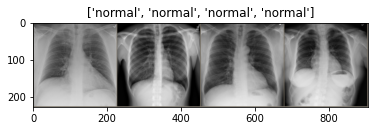

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
  
# Get a batch of training data
inputs, classes = next(iter(train_image_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## COVID-Net

In [0]:
class PEPX_Module(nn.Module):
    def __init__(self, inplanes, planes):
        super(PEPX_Module, self).__init__()

        self.module = nn.Sequential(
                          nn.Conv2d(in_channels=inplanes, out_channels=inplanes, kernel_size=1),# conv1x1
                          nn.BatchNorm2d(inplanes),
                          nn.ReLU(inplace=True),

                          nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=1), # conv1x1
                          nn.BatchNorm2d(planes),
                          nn.ReLU(inplace=True),

                          nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, groups=planes, padding=1), # DWConv3x3
                          nn.BatchNorm2d(planes),
                          nn.ReLU(inplace=True),

                          nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=1), # conv1x1
                          nn.BatchNorm2d(planes),
                          nn.ReLU(inplace=True),

                          nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=1),# conv1x1
                          nn.BatchNorm2d(planes),
                          nn.ReLU(inplace=True)
                       )

    def forward(self, x):
        return self.module(x)

class CovidNet(nn.Module):
    def __init__(self, n_classes=3):
        super(CovidNet, self).__init__()
        
        self.conv1 = nn.Sequential(
                      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
                      nn.BatchNorm2d(64),
                      nn.ReLU(inplace=True)
                     )
        self.conv1_1x1 = nn.Sequential(
                      nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(inplace=True)
                     )
        self.conv2_1x1 = nn.Sequential(
                      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(inplace=True)
                     )
        self.conv3_1x1 = nn.Sequential(
                      nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
                      nn.BatchNorm2d(1024),
                      nn.ReLU(inplace=True)
                     )
        self.conv4_1x1 = nn.Sequential(
                      nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1),
                      nn.BatchNorm2d(2048),
                      nn.ReLU(inplace=True)
                     )

        self.pepxmodule1_1 = PEPX_Module(64, 256)
        self.pepxmodule1_2 = PEPX_Module(256, 256)
        self.pepxmodule1_3 = PEPX_Module(256, 256)
        self.pepxmodule2_1 = PEPX_Module(256, 512)
        self.pepxmodule2_2 = PEPX_Module(512, 512)
        self.pepxmodule2_3 = PEPX_Module(512, 512)
        self.pepxmodule2_4 = PEPX_Module(512, 512)
        self.pepxmodule3_1 = PEPX_Module(512, 1024)
        self.pepxmodule3_2 = PEPX_Module(1024, 1024)
        self.pepxmodule3_3 = PEPX_Module(1024, 1024)
        self.pepxmodule3_4 = PEPX_Module(1024, 1024)
        self.pepxmodule3_5 = PEPX_Module(1024, 1024)
        self.pepxmodule3_6 = PEPX_Module(1024, 1024)
        self.pepxmodule4_1 = PEPX_Module(1024, 2048)
        self.pepxmodule4_2 = PEPX_Module(2048, 2048)
        self.pepxmodule4_3 = PEPX_Module(2048, 2048)

        self.maxpool = nn.MaxPool2d(kernel_size=2)  
        self.relu = nn.ReLU(inplace=True)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7 * 7 * 2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.classifier = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.maxpool(self.conv1(x))
        out_conv1_1x1 = self.conv1_1x1(x)

        pepx1_1 = self.pepxmodule1_1(x)
        pepx1_2 = self.pepxmodule1_2(pepx1_1 + out_conv1_1x1)
        pepx1_3 = self.pepxmodule1_3(pepx1_2 + pepx1_1 + out_conv1_1x1)

        out_conv2_1x1 = self.maxpool(self.conv2_1x1(pepx1_2 + pepx1_1 + pepx1_3 +  out_conv1_1x1))

        pepx2_1 = self.pepxmodule2_1(self.maxpool(pepx1_3) + self.maxpool(pepx1_1) + self.maxpool(pepx1_2) + 
                              self.maxpool(out_conv1_1x1))
        pepx2_2 = self.pepxmodule2_2(pepx2_1 + out_conv2_1x1)
        pepx2_3 = self.pepxmodule2_3(pepx2_2 + pepx2_1 + out_conv2_1x1)
        pepx2_4 = self.pepxmodule2_4(pepx2_3 + pepx2_1 + pepx2_2 + out_conv2_1x1)

        out_conv3_1x1 = self.maxpool(self.conv3_1x1(pepx2_2 + pepx2_1 + pepx2_3 + pepx2_4 + out_conv2_1x1))

        pepx3_1 = self.pepxmodule3_1(self.maxpool(pepx2_4) + self.maxpool(pepx2_1) + self.maxpool(pepx2_2) + 
                              self.maxpool(pepx2_3) + self.maxpool(out_conv2_1x1)
                              )
        pepx3_2 = self.pepxmodule3_2(pepx3_1 + out_conv3_1x1)
        pepx3_3 = self.pepxmodule3_3(pepx3_1 + pepx3_2)
        pepx3_4 = self.pepxmodule3_4(pepx3_1 + pepx3_2 + pepx3_3)
        pepx3_5 = self.pepxmodule3_5(pepx3_1 + pepx3_2 + pepx3_3 + pepx3_4)
        pepx3_6 = self.pepxmodule3_6(pepx3_1 + pepx3_2 + pepx3_3 + pepx3_4 + pepx3_5)

        out_conv4_1x1 = self.maxpool(self.conv4_1x1(pepx3_1 + pepx3_2 + pepx3_3 + pepx3_4 + pepx3_5+ pepx3_6 + out_conv3_1x1))

        pepx4_1 = self.pepxmodule4_1(self.maxpool(pepx3_1) + self.maxpool(pepx3_2) + self.maxpool(pepx3_2) + 
                              self.maxpool(pepx3_4)+ self.maxpool(pepx3_5)+ self.maxpool(pepx3_6) + self.maxpool(out_conv3_1x1)
                              )
        pepx4_2 = self.pepxmodule4_2(pepx4_1 + out_conv4_1x1)
        pepx4_3 = self.pepxmodule4_3(pepx4_1 + pepx4_2 + out_conv4_1x1)
        flattened = self.flatten(pepx4_1 + pepx4_2 + pepx4_3 + out_conv4_1x1)

        fc_1024 = self.relu(self.fc1(flattened))
        fc_256 = self.relu(self.fc2(fc_1024))
        logits = self.classifier(fc_256)
        return logits

In [0]:
def test_model():
    net = CovidNet()
    inp = torch.randn(4,3,224,224)
    output = net(inp)
    print(output.shape)

# test_model()  

## Focal Loss

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha = 1.0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps

    def forward(self, input, target):
        y = F.one_hot(target, input.size(-1))
        logit = F.softmax(input, dim=-1) # dim along which softmax will be computed (dim=-1 = last dimension = no_of_classes)
        logit = logit.clamp(self.eps, 1. - self.eps) # make range [self.eps, 1. - self.eps]
        
        loss = -self.alpha * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.sum()

## Test Loss

In [0]:
def test_loss():
    no_of_classes = 5
    logits = torch.rand(10,no_of_classes)
    labels = torch.randint(0,no_of_classes, size = (10,))
    gamma = 2.0
    criterion = FocalLoss(gamma=gamma)
    loss = criterion(logits, labels)
    print(loss)

# test_loss()

## Set Model & Hyperparameter

In [0]:
# model = models.resnet18(pretrained=True)
model = models.resnext50_32x4d(pretrained=True)
# model = CovidNet()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [0]:
# for param in model.parameters():
#     param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    # nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Linear(256,len(class_names))
)
# model.load_state_dict(torch.load("/content/drive/My Drive/Kaggle/COVID-ResNet18.pth"))
model.to(device)
print(model)

criterion = FocalLoss(gamma=2.0, alpha=1.0)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, min_lr=1e-5, verbose=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Train Model

In [0]:
EPOCHS = 15
nn_output = []
interval = 1000
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

def get_num_correct(outputs, labels):
    _, preds  = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_correct = 0
    model.train()
    
    for batch_idx, data in enumerate(train_image_dataloader):
        
        X = data[0].to(device) # X is the batch of features
        y = data[1].to(device) # y is the batch of targets.
        
        optimizer.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = model(X)  # pass in the reshaped batch (recall they are 224x224)
        tloss = criterion(output, y)  # calc and grab the loss value
        tloss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients 
        
        epoch_loss += tloss.item()
        epoch_correct += get_num_correct(output, y)

        num_samples = batch_idx * BATCH_SIZE + 1
        
        if num_samples % interval == 1:
          print("Epoch:{:2d} Sample:{:5d}/{:5d}".format(epoch, num_samples,len(train_image_dataloader) * BATCH_SIZE))

    
    # Evaluation with the validation set
    model.eval() # eval mode
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        # First Validation Set
        for inputs,labels in val_image_dataloader:
            X = inputs.to(device)
            y = labels.to(device)
            
            preds = model(X) # get predictions
            vloss = criterion(preds, y) # calculate the loss
            
            val_correct += get_num_correct(preds, y)
            val_loss += vloss.item()
        
    tmp_nn_output = [epoch + 1,EPOCHS,
                     epoch_loss/dataset_sizes['train'],epoch_correct.double()/dataset_sizes['train']*100,
                     val_loss/dataset_sizes['val'], val_correct.double()/dataset_sizes['val']*100, 
                    ]
    
    # scheduler step
    scheduler.step(val_loss/dataset_sizes['val'])

    test_acc = val_correct.double()/dataset_sizes['val']*100

    if test_acc >= best_acc:
      best_acc = test_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    nn_output.append(tmp_nn_output)
    
    # Print the loss and accuracy for the validation set
    print('Epoch[{}/{}] Train loss: {:.6f} acc: {:.3f} | Valid loss: {:.6f} acc: {:.3f}'
        .format(*tmp_nn_output))

Epoch: 0 Sample:    1/16608
Epoch: 0 Sample: 1001/16608
Epoch: 0 Sample: 2001/16608
Epoch: 0 Sample: 3001/16608
Epoch: 0 Sample: 4001/16608
Epoch: 0 Sample: 5001/16608
Epoch: 0 Sample: 6001/16608
Epoch: 0 Sample: 7001/16608
Epoch: 0 Sample: 8001/16608
Epoch: 0 Sample: 9001/16608
Epoch: 0 Sample:10001/16608
Epoch: 0 Sample:11001/16608
Epoch: 0 Sample:12001/16608
Epoch: 0 Sample:13001/16608
Epoch: 0 Sample:14001/16608
Epoch: 0 Sample:15001/16608
Epoch: 0 Sample:16001/16608
Epoch[1/15] Train loss: 0.116473 acc: 85.891 | Valid loss: 0.061698 acc: 92.985
Epoch: 1 Sample:    1/16608
Epoch: 1 Sample: 1001/16608
Epoch: 1 Sample: 2001/16608
Epoch: 1 Sample: 3001/16608
Epoch: 1 Sample: 4001/16608
Epoch: 1 Sample: 5001/16608
Epoch: 1 Sample: 6001/16608
Epoch: 1 Sample: 7001/16608
Epoch: 1 Sample: 8001/16608
Epoch: 1 Sample: 9001/16608
Epoch: 1 Sample:10001/16608
Epoch: 1 Sample:11001/16608
Epoch: 1 Sample:12001/16608
Epoch: 1 Sample:13001/16608
Epoch: 1 Sample:14001/16608
Epoch: 1 Sample:15001/16

## Save Best Model

In [0]:
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(),"/content/drive/My Drive/Kaggle/COVID-ResNext50_32x4d.pth")

## Validate Model

In [0]:
model.eval()
test_correct = 0
test_loss = 0

with torch.no_grad():
# Test Set.. 
  for inputs,labels in val_image_dataloader:
    X = inputs.to(device)
    y = labels.to(device) # size => (3)
            
    preds = model(X) # get predictions..size=> (10,3)
    tstloss = criterion(preds, y) # calculate the loss
            
    test_correct += get_num_correct(preds, y)
    test_loss += tstloss.item()

print("Test Acc: {:.3f}".format(test_correct.double()/dataset_sizes['val']*100))

Test Acc: 95.289


In [0]:
import pandas as pd

pd_results = pd.DataFrame(nn_output,
    columns = ['epoch','total_epochs','train_loss','train_acc','valid_loss','valid_acc'])
                         
pd_results.head()

,epoch,total_epochs,train_loss,train_acc,valid_loss,valid_acc
0,1,15,0.116473,"tensor(85.8915, device='cuda:0', dtype=torch.f...",0.061698,"tensor(92.9852, device='cuda:0', dtype=torch.f..."
1,2,15,0.081872,"tensor(90.8894, device='cuda:0', dtype=torch.f...",0.062571,"tensor(93.1900, device='cuda:0', dtype=torch.f..."
2,3,15,0.069302,"tensor(92.1599, device='cuda:0', dtype=torch.f...",0.051825,"tensor(93.9068, device='cuda:0', dtype=torch.f..."
3,4,15,0.060339,"tensor(93.0391, device='cuda:0', dtype=torch.f...",0.046468,"tensor(94.4188, device='cuda:0', dtype=torch.f..."
4,5,15,0.050747,"tensor(93.9905, device='cuda:0', dtype=torch.f...",0.051114,"tensor(93.7020, device='cuda:0', dtype=torch.f..."


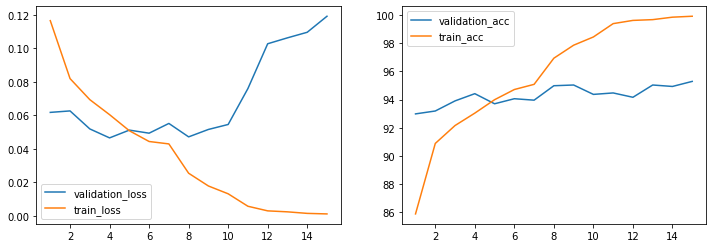

In [0]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(pd_results['epoch'],pd_results['valid_loss'], label='validation_loss')
axes[0].plot(pd_results['epoch'],pd_results['train_loss'], label='train_loss')
# axes[0].plot(pd_results['epoch'],pd_results['test_loss'], label='test_loss')
axes[0].legend()

axes[1].plot(pd_results['epoch'],pd_results['valid_acc'], label='validation_acc')
axes[1].plot(pd_results['epoch'],pd_results['train_acc'], label='train_acc')
# axes[1].plot(pd_results['epoch'],pd_results['test_acc'], label='test_acc')
axes[1].legend()

## Confusion Matrix

In [0]:
model.eval()
test_correct = 0
test_loss = 0

confusion_matrix = torch.zeros(len(class_names),len(class_names))

covid_fp, covid_tp = 0, 0

with torch.no_grad():
# Test Set.. 
  for inputs,labels in val_image_dataloader:
    X = inputs.to(device) # size => (Batch_size,3,224,224)
    y = labels.to(device) # size => (Batch_size)
            
    outputs = model(X) # get predictions..size=> (Batch_size,no_of_classes)
    _, preds = torch.max(outputs, 1) # preds size(Batch_size)       

    for t, p in zip(labels.view(-1), preds.view(-1)):
      if t == 2 and p == 2:
        covid_tp += 1
      elif p == 2 and t != 2:
        covid_fp += 1
      confusion_matrix[t, p] += 1

print(confusion_matrix)
print("Covid-19 precision: ",covid_tp/(covid_tp+covid_fp))

tensor([[1009.,   47.,    2.],
        [  34.,  847.,    4.],
        [   3.,    2.,    5.]])
Covid-19 precision:  0.45454545454545453
